# Pipeline Estensione: End-to-End Learning (YOLO + ResNet Translation + Rotation)

> Approccio avanzato: ResNet apprende sia translation che rotation

TODO:
- Improve pipeline (make it complete)
- Fix low threshold (as shown in images, the model identified two images)
- Show loss (ADD) in result images
- Improve overall results picture quality

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Carica modelli pretrained**
3. **Pipeline completa** YOLO detection → crop → 6D pose estimation

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator_endtoend import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


## 2. Carica dataset LineMOD

In [2]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


## 3.Carica Modelli Pre-Trained

Carica il checkpoint salvato e testa su sample del test set.

In [3]:
# ====== CARICAMENTO MODELLI PRE-TRAINED ======
from models.yolo_detector import YOLODetector

# 1. YOLO Fine-tuned per detection
print("=" * 60)
print("📦 CARICAMENTO YOLO DETECTOR")
print("=" * 60)

YOLO_MODEL = 'yolo_train10'
yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / YOLO_MODEL / 'weights' / 'best.pt'

if yolo_weights.exists():
    print(f"✅ Carico YOLO: {yolo_weights.relative_to(project_root)}\n")
    yolo_detector = YOLODetector(
        model_name=str(yolo_weights),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO caricato con successo!\n")
else:
    print(f"❌ YOLO weights non trovati: {yolo_weights}")
    print(f"   Allena prima YOLO (vedi test_yolo2_finetuning.ipynb)\n")
    yolo_detector = None

# 2. PoseEstimator (ResNet50) per 6D pose
print("=" * 60)
print("📦 CARICAMENTO POSE ESTIMATOR (ResNet50)")
print("=" * 60)

RESNET_MODEL = "pose_stable_train100"
checkpoint_dir = project_root / 'checkpoints' / 'pose' / RESNET_MODEL
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con training
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ PoseEstimator caricato e in modalità eval!\n")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train100' / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train70' / 'weights' / 'best.pt'}")
    print(f"   3. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train30' / 'weights' / 'best.pt'}")
    print(f"   4. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training (vedi test_yolo3_pose_finetuning.ipynb)")
    print(f"   Oppure cambia RESNET_MODEL con un esperimento esistente\n")
    model = None

# Riepilogo modelli caricati
print("=" * 60)
print("📋 RIEPILOGO MODELLI CARICATI")
print("=" * 60)
print(f"YOLO Detector:    {'✅ Caricato' if yolo_detector is not None else '❌ Non disponibile'}")
print(f"PoseEstimator:    {'✅ Caricato' if model is not None else '❌ Non disponibile'}")
if yolo_detector is not None and model is not None:
    print(f"\n🚀 Tutto pronto per la pipeline completa!")
else:
    print(f"\n⚠️  Alcuni modelli mancano. Verifica i checkpoint.")
print("=" * 60)

📦 CARICAMENTO YOLO DETECTOR
✅ Carico YOLO: checkpoints/yolo/yolo_train10/weights/best.pt

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train10/weights/best.pt
✅ YOLO caricato con successo!

📦 CARICAMENTO POSE ESTIMATOR (ResNet50)
✅ Carico checkpoint: checkpoints/pose/pose_stable_train100/weights/best.pt



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
📊 Checkpoint info:
   Epoch: 99
   Loss: 18.3879
   Trans Loss: 5.8059
   Rot Loss: 0.25

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 100
      warmup_epochs: 5
      lr_backbone: 5e-06
      lr_head: 0.0001
      batch_size: 64
      accumulation_steps: 2
      effective_batch_size: 128
      use_amp: True
      lambda_trans: 1.0
      lambda_rot: 50.0
      dropout: 0.5
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: cuda
      image_size: 224
      crop_margin: 0.15

   Device: mps

✅ PoseEstimator caricato e in modalità eval!

📋 RIEPILOGO MODELLI CARICATI
YOLO Detector:    ✅ Caricato
PoseEstimator:    ✅ Caricato

🚀 Tutto pronto per la pipeline completa!


## 4. Pipeline Completa: YOLO Detection + Pose Estimation

Test della pipeline completa end-to-end:
1. YOLO11n fine-tuned rileva oggetti e bbox
2. Crop immagine attorno al bbox
3. PoseEstimator predice 6D pose (quaternion + translation)

🔗 PIPELINE COMPLETA: YOLO Detection + Pose Estimation + Ground Truth Comparison

📋 Modelli utilizzati:
   YOLO: best.pt
   PoseEstimator: pose_stable_train100
   Device: mps

🎲 Selezione immagine casuale dal dataset...

📷 Immagine selezionata:
   Path: data/14/rgb/0323.png
   Size: 640x480
   Image ID: 323
   Totale immagini disponibili: 15800

📂 Caricamento ground truth dal dataset...
✅ Ground truth caricato:
   Translation: [46.4, -121.6, 930.2] mm
   Quaternion: [0.319, 0.674, 0.612, -0.262]

🔍 Step 1: YOLO Detection...
   Rilevati 1 oggetti

✂️  Step 2: Crop e Pose Estimation per ogni oggetto...

   [1/1] lamp (conf=0.95)
         Bbox: [321, 90, 404, 231]
         Quaternion: [-0.041, -0.214, -0.917, 0.335]
         Translation: [-29.1, -49.5, 515.1] mm
         (modello output: [-0.029, -0.050, 0.515] m)

📊 Step 3: Confronto con Ground Truth...

📋 TABELLA COMPARATIVA: Predizioni vs Ground Truth
 Oggetto Confidence           Pred T (mm)             GT T (mm) Trans Error (mm)      

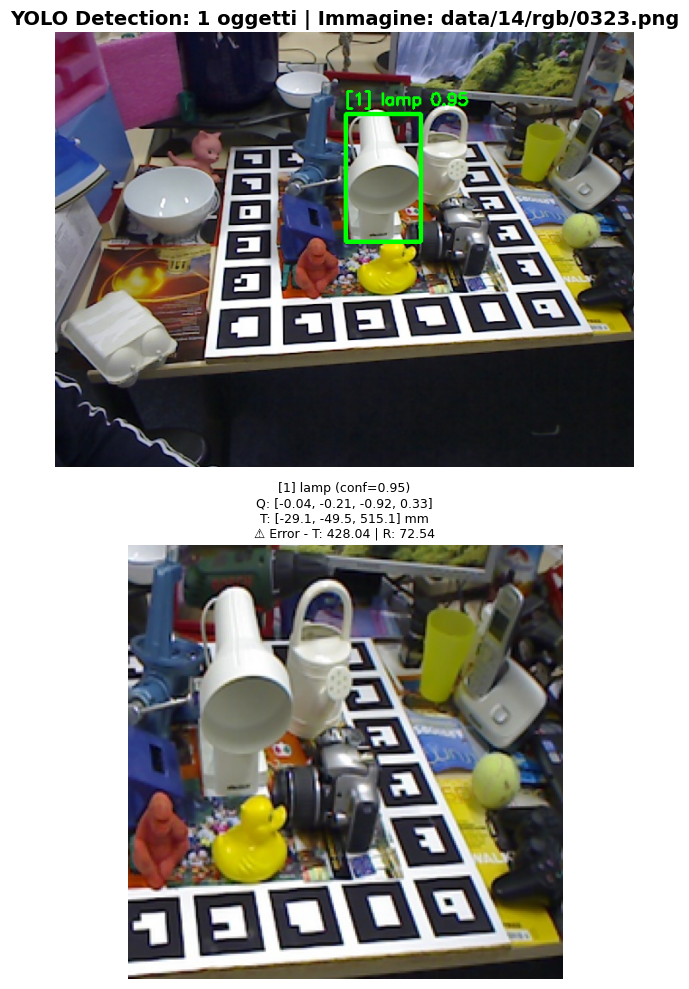

✅ PIPELINE COMPLETATA!
   Oggetti rilevati e pose stimati: 1
   YOLO usato: best.pt
   PoseEstimator usato: pose_stable_train100
   Ground Truth: ✅ Confronto disponibile

💡 Nota: I numeri [1], [2], ... indicano la stessa detection in:
   • Bbox YOLO sull'immagine originale
   • Crop mostrato sotto con la posa stimata
   • Riga della tabella comparativa

🎲 Esegui di nuovo questa cella per testare su un'altra immagine casuale!


In [6]:
# ====== PIPELINE COMPLETA: YOLO → CROP → POSE ESTIMATION ======
from utils.transforms import crop_image_from_bbox, get_pose_transforms
from PIL import Image
from scipy.spatial.transform import Rotation

# Verifica che i modelli siano caricati
if yolo_detector is None or model is None:
    print("❌ Errore: I modelli non sono caricati!")
    print(f"   YOLO Detector: {'✅' if yolo_detector is not None else '❌'}")
    print(f"   PoseEstimator: {'✅' if model is not None else '❌'}")
    print("\n   Esegui prima la cella precedente per caricare i modelli.")
else:
    print("=" * 60)
    print("🔗 PIPELINE COMPLETA: YOLO Detection + Pose Estimation + Ground Truth Comparison")
    print("=" * 60)
    
    print(f"\n📋 Modelli utilizzati:")
    print(f"   YOLO: {yolo_weights.name}")
    print(f"   PoseEstimator: {RESNET_MODEL}")
    print(f"   Device: {Config.DEVICE}\n")
    
    # ✅ SELEZIONE IMMAGINE CASUALE: Trova tutte le immagini disponibili
    print("🎲 Selezione immagine casuale dal dataset...\n")
    
    # Lista tutte le cartelle degli oggetti
    data_root = Config.LINEMOD_ROOT / 'data'
    available_images = []
    
    for obj_folder in sorted(data_root.iterdir()):
        if obj_folder.is_dir() and obj_folder.name.isdigit():
            rgb_folder = obj_folder / 'rgb'
            if rgb_folder.exists():
                # Trova tutte le immagini PNG
                images_in_folder = list(rgb_folder.glob('*.png'))
                available_images.extend(images_in_folder)
    
    if not available_images:
        print("❌ Nessuna immagine trovata nel dataset")
    else:
        # Seleziona un'immagine casuale
        test_img_path = random.choice(available_images)
        test_image = np.array(Image.open(test_img_path).convert('RGB'))
        
        # Estrai informazioni dal path
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        img_id = int(img_name.split('.')[0])  # Estrai ID dell'immagine (es. '0000.png' -> 0)
        
        print(f"📷 Immagine selezionata:")
        print(f"   Path: data/{obj_id}/rgb/{img_name}")
        print(f"   Size: {test_image.shape[1]}x{test_image.shape[0]}")
        print(f"   Image ID: {img_id}")
        print(f"   Totale immagini disponibili: {len(available_images)}\n")
        
        # Carica ground truth per questa immagine
        print("📂 Caricamento ground truth dal dataset...")
        gt_path = data_root / obj_id / 'gt.yml'
        if gt_path.exists():
            with open(gt_path, 'r') as f:
                gt_data = yaml.safe_load(f)
            
            # Il ground truth è strutturato come: {img_id: [{obj_id: ..., cam_R_m2c: ..., cam_t_m2c: ...}]}
            if img_id in gt_data and len(gt_data[img_id]) > 0:
                gt_pose = gt_data[img_id][0]  # Prendi la prima pose (in LineMOD c'è un oggetto per immagine)
                gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
                gt_t = np.array(gt_pose['cam_t_m2c']).flatten()  # ✅ GT è già in millimetri
                
                # Converti rotazione da matrice a quaternion (w, x, y, z)
                gt_quat = Rotation.from_matrix(gt_R).as_quat()  # Scipy restituisce (x, y, z, w)
                gt_quat = np.array([gt_quat[3], gt_quat[0], gt_quat[1], gt_quat[2]])  # Converti a (w, x, y, z)
                
                print(f"✅ Ground truth caricato:")
                print(f"   Translation: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm")
                print(f"   Quaternion: [{gt_quat[0]:.3f}, {gt_quat[1]:.3f}, {gt_quat[2]:.3f}, {gt_quat[3]:.3f}]\n")
                has_gt = True
            else:
                print(f"⚠️  Ground truth non trovato per image ID {img_id}")
                has_gt = False
        else:
            print(f"⚠️  File gt.yml non trovato: {gt_path}")
            has_gt = False
        
        # Step 1: YOLO detection
        print("🔍 Step 1: YOLO Detection...")
        detections = yolo_detector.detect_objects(test_image, conf_threshold=0.3)
        print(f"   Rilevati {len(detections)} oggetti\n")
        
        if len(detections) == 0:
            print("❌ Nessun oggetto rilevato. Prova con un'altra immagine o lower confidence threshold.")
            print("   💡 Esegui di nuovo la cella per selezionare un'altra immagine casuale")
        else:
            # Step 2: Crop e Pose Estimation per ogni detection
            print("✂️  Step 2: Crop e Pose Estimation per ogni oggetto...\n")
            
            pose_transforms = get_pose_transforms(train=False)
            results = []
            
            for idx, det in enumerate(detections):
                bbox = det['bbox']  # [x1, y1, x2, y2]
                obj_name = det['class_name']
                conf = det['confidence']
                
                print(f"   [{idx+1}/{len(detections)}] {obj_name} (conf={conf:.2f})")
                print(f"         Bbox: [{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]")
                
                # Crop con margin (ritorna già PIL Image)
                cropped = crop_image_from_bbox(
                    test_image,
                    bbox,
                    margin=Config.POSE_CROP_MARGIN,
                    output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
                )
                
                # Preprocessing (cropped è già PIL Image, no fromarray needed)
                cropped_tensor = pose_transforms(cropped)
                cropped_tensor = cropped_tensor.unsqueeze(0).to(Config.DEVICE)
                
                # Pose prediction con il modello caricato
                with torch.no_grad():
                    pred_quat, pred_trans = model(cropped_tensor)
                
                pred_quat = pred_quat[0].cpu().numpy()
                pred_trans = pred_trans[0].cpu().numpy()
                
                # ✅ IMPORTANTE: Riconverti da metri a millimetri!
                # Il modello predice in metri (training scale: mm / 1000)
                # Ma il ground truth è in millimetri, quindi moltiplichiamo x 1000
                pred_trans_mm = pred_trans * 1000.0  # meters → millimeters
                
                results.append({
                    'bbox': bbox,
                    'class_name': obj_name,
                    'confidence': conf,
                    'quaternion': pred_quat,
                    'translation': pred_trans_mm,  # ✅ Salva in millimetri
                    'cropped': np.array(cropped)  # crop "pulito", solo per visualizzazione
                })
                
                print(f"         Quaternion: [{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]")
                print(f"         Translation: [{pred_trans_mm[0]:.1f}, {pred_trans_mm[1]:.1f}, {pred_trans_mm[2]:.1f}] mm")
                print(f"         (modello output: [{pred_trans[0]:.3f}, {pred_trans[1]:.3f}, {pred_trans[2]:.3f}] m)\n")
            
            # Step 3: Creazione tabella comparativa con ground truth
            print("📊 Step 3: Confronto con Ground Truth...\n")
            
            if has_gt:
                # Crea DataFrame con confronto
                comparison_data = []
                
                for idx, res in enumerate(results):
                    pred_quat = res['quaternion']
                    pred_trans = res['translation']  # ✅ Ora è già in millimetri
                    
                    # Calcola errore di traslazione (distanza euclidea in mm)
                    trans_error = np.linalg.norm(pred_trans - gt_t)
                    
                    # Calcola errore di rotazione (distanza angolare in gradi)
                    # Converti quaternion a matrice di rotazione
                    pred_R = Rotation.from_quat([pred_quat[1], pred_quat[2], pred_quat[3], pred_quat[0]]).as_matrix()
                    
                    # Calcola la differenza di rotazione: R_error = R_pred^T * R_gt
                    R_error = pred_R.T @ gt_R
                    
                    # Estrai l'angolo dall'asse-angolo della matrice di errore
                    # trace(R) = 1 + 2*cos(theta)
                    trace = np.trace(R_error)
                    rot_error_rad = np.arccos(np.clip((trace - 1) / 2, -1, 1))
                    rot_error_deg = np.degrees(rot_error_rad)
                    
                    comparison_data.append({
                        'Oggetto': f"[{idx+1}] {res['class_name']}",
                        'Confidence': f"{res['confidence']:.3f}",
                        'Pred T (mm)': f"[{pred_trans[0]:.1f}, {pred_trans[1]:.1f}, {pred_trans[2]:.1f}]",
                        'GT T (mm)': f"[{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}]",
                        'Trans Error (mm)': f"{trans_error:.2f}",
                        'Pred Q (w,x,y,z)': f"[{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]",
                        'GT Q (w,x,y,z)': f"[{gt_quat[0]:.3f}, {gt_quat[1]:.3f}, {gt_quat[2]:.3f}, {gt_quat[3]:.3f}]",
                        'Rot Error (deg)': f"{rot_error_deg:.2f}"
                    })
                
                df_comparison = pd.DataFrame(comparison_data)
                
                print("📋 TABELLA COMPARATIVA: Predizioni vs Ground Truth")
                print("=" * 150)
                
                # Stampa la tabella con formattazione migliorata
                pd.set_option('display.max_columns', None)
                pd.set_option('display.width', None)
                pd.set_option('display.max_colwidth', None)
                print(df_comparison.to_string(index=False))
                print("=" * 150)
                print(f"\n📏 Metriche Aggregate:")
                
                # Estrai valori numerici per calcolare medie
                trans_errors = [float(d['Trans Error (mm)']) for d in comparison_data]
                rot_errors = [float(d['Rot Error (deg)']) for d in comparison_data]
                
                print(f"   Translation Error - Media: {np.mean(trans_errors):.2f} mm | Min: {np.min(trans_errors):.2f} mm | Max: {np.max(trans_errors):.2f} mm")
                print(f"   Rotation Error    - Media: {np.mean(rot_errors):.2f}° | Min: {np.min(rot_errors):.2f}° | Max: {np.max(rot_errors):.2f}°\n")
            else:
                print("⚠️  Ground truth non disponibile per questa immagine. Visualizzo solo le predizioni.\n")
            
            # Step 4: Visualizzazione
            print(f"🎨 Step 4: Visualizzazione risultati...\n")
            print("💡 Corrispondenza:")
            print("   • [k] sull'immagine con YOLO = detection k-esima")
            print("   • [k] sul crop = stesso oggetto passato al PoseEstimator")
            print("   • [k] nella tabella = stessa detection con errori\n")
            
            n_detections = len(results)
            n_cols = min(3, n_detections)
            n_rows = (n_detections + n_cols - 1) // n_cols
            
            # Create figure with GridSpec for custom layout
            fig = plt.figure(figsize=(15, 5 * (n_rows + 1)))
            
            # ✅ Draw bounding boxes sull'immagine originale
            img_with_bbox = test_image.copy()
            try:
                import cv2
                colors_bgr = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
                for idx, res in enumerate(results):
                    x1, y1, x2, y2 = res['bbox']
                    color = colors_bgr[idx % len(colors_bgr)]
                    cv2.rectangle(img_with_bbox, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
                    # Label con numero per tracciare corrispondenza
                    label = f"[{idx+1}] {res['class_name']} {res['confidence']:.2f}"
                    cv2.putText(
                        img_with_bbox,
                        label,
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        color,
                        2
                    )
            except ImportError:
                print("⚠️  OpenCV non installato. Visualizzazione senza bounding boxes...")
                print("   Per installarla: pip install opencv-python\n")
            
            # Immagine originale con bbox (riga in alto, tutte le colonne)
            ax_orig = plt.subplot2grid((n_rows + 1, n_cols), (0, 0), colspan=n_cols)
            ax_orig.imshow(img_with_bbox)
            ax_orig.set_title(
                f"YOLO Detection: {n_detections} oggetti | Immagine: data/{obj_id}/rgb/{img_name}", 
                fontsize=14, fontweight='bold'
            )
            ax_orig.axis('off')
            
            # Crops con pose (righe sotto) - Numerati per corrispondenza
            for idx, res in enumerate(results):
                row = (idx // n_cols) + 1
                col = idx % n_cols
                ax = plt.subplot2grid((n_rows + 1, n_cols), (row, col))
                ax.imshow(res['cropped'])
                
                # Aggiungi errori alla visualizzazione se disponibili
                if has_gt:
                    trans_err = comparison_data[idx]['Trans Error (mm)']
                    rot_err = comparison_data[idx]['Rot Error (deg)']
                    title = (
                        f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                        f"Q: [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                        f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]\n"
                        f"T: [{res['translation'][0]:.1f}, {res['translation'][1]:.1f}, {res['translation'][2]:.1f}] mm\n"
                        f"⚠️ Error - T: {trans_err} | R: {rot_err}"
                    )
                else:
                    title = (
                        f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                        f"Q: [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                        f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]\n"
                        f"T: [{res['translation'][0]:.1f}, {res['translation'][1]:.1f}, {res['translation'][2]:.1f}] mm"
                    )
                ax.set_title(title, fontsize=9)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"=" * 60)
            print(f"✅ PIPELINE COMPLETATA!")
            print(f"=" * 60)
            print(f"   Oggetti rilevati e pose stimati: {n_detections}")
            print(f"   YOLO usato: {yolo_weights.name}")
            print(f"   PoseEstimator usato: {RESNET_MODEL}")
            print(f"   Ground Truth: {'✅ Confronto disponibile' if has_gt else '❌ Non disponibile'}")
            print(f"\n💡 Nota: I numeri [1], [2], ... indicano la stessa detection in:")
            print(f"   • Bbox YOLO sull'immagine originale")
            print(f"   • Crop mostrato sotto con la posa stimata")
            print(f"   • Riga della tabella comparativa")
            print(f"\n🎲 Esegui di nuovo questa cella per testare su un'altra immagine casuale!")
            print(f"=" * 60)

## 5. Analisi Risultati e Ottimizzazioni

### 📊 Benchmark LineMOD (Standard)
| Metrica | Ottimo | Buono | Accettabile |
|---------|--------|-------|-------------|
| Translation Error | <10mm | <20mm | <50mm |
| Rotation Error | <5° | <10° | <15° |
| ADD Accuracy | >95% | >90% | >80% |

### ⚠️ Problemi Rilevati
**I risultati attuali (~428mm translation, ~72° rotation) sono MOLTO al di sotto degli standard.**

### 🔧 Possibili Cause e Soluzioni

#### 1. **Loss Weights Non Bilanciati**
```python
# Config attuale:
LAMBDA_TRANS = 1.0    # Translation loss weight
LAMBDA_ROT = 50.0     # Rotation loss weight (troppo alto?)
```
**Problema**: Peso rotazione 50x maggiore → il modello si concentra troppo sulla rotazione ignorando translation.

**Soluzione**: Riequilibrare i pesi basandosi sugli errori relativi.

#### 2. **Normalizzazione Inadeguata**
Il modello predice in metri (poi converte a mm), ma potrebbe soffrire di scale mismatch.

**Soluzione**: Normalizzare translation con z-score o usare log-space per depth.

#### 3. **Crop Margin Subottimale**
```python
POSE_CROP_MARGIN = 0.15  # 15% di margine
```
**Problema**: Potrebbe tagliare contesto importante o includere troppo background.

**Soluzione**: Testare valori 0.05-0.25 con grid search.

#### 4. **Data Augmentation Insufficiente**
```python
POSE_COLOR_JITTER = True  # Solo color jitter
```
**Problema**: Mancano augmentation geometriche (rotazioni, scale, blur).

**Soluzione**: Aggiungere RandomAffine, GaussianBlur, RandomErasing.

#### 5. **Learning Rate Troppo Alto**
```python
POSE_LR = 1e-4
```
**Problema**: Potrebbe non convergere a un buon minimo.

**Soluzione**: Provare 5e-5 o 1e-5 con warmup + cosine annealing.

#### 6. **Training Troppo Breve?**
```python
POSE_EPOCHS = 100
```
Verifica se la loss ha raggiunto plateau. Se continua a scendere → train più a lungo.

#### 7. **Quaternion Normalization**
**Problema Critico**: I quaternion predetti devono essere normalizzati (norma=1).

**Soluzione**: Aggiungere normalizzazione nel forward pass del modello.

🔬 TEST SU MULTIPLE IMMAGINI (Statistica Robusta)

🎲 Testing su 20 immagini casuali...



Processing: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


📊 STATISTICHE AGGREGATE
   Immagini testate: 20
   Predizioni riuscite: 17
   Detection fallite: 3
   Success rate: 85.0%

📏 TRANSLATION ERROR (mm):
   Media:   510.63 mm
   Mediana: 468.49 mm
   Std Dev: 142.77 mm
   Min:     303.12 mm
   Max:     796.59 mm
   Percentile 25: 390.03 mm
   Percentile 75: 598.55 mm

🔄 ROTATION ERROR (deg):
   Media:   101.86°
   Mediana: 113.27°
   Std Dev: 45.43°
   Min:     21.05°
   Max:     177.78°
   Percentile 25: 70.28°
   Percentile 75: 133.23°

📈 DISTRIBUZIONE ERRORI:
   Translation < 50mm:  0.0%
   Translation < 100mm: 0.0%
   Rotation < 15°:      0.0%
   Rotation < 30°:      11.8%


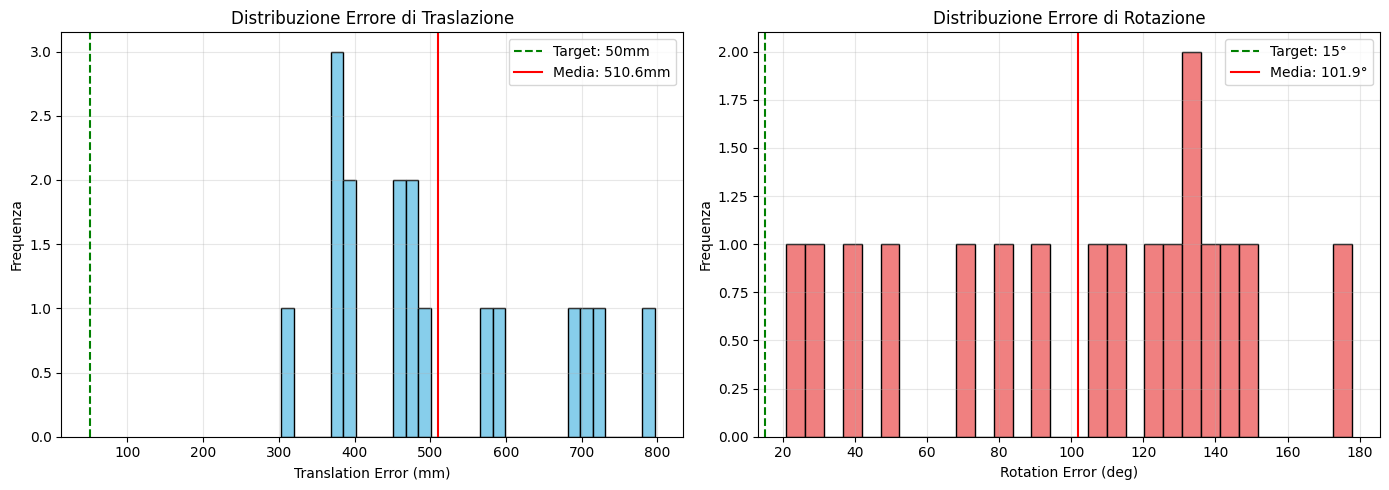


🎯 VALUTAZIONE FINALE
   ❌ INSUFFICIENTE - Re-training necessario

💡 RACCOMANDAZIONI:
   • Translation troppo alta → Rivedere LAMBDA_TRANS e normalizzazione
   • Rotation troppo alta → Verificare normalizzazione quaternion
   • Aumentare epoche di training (attuale: 100)
   • Testare learning rate più bassi (attuale: 0.0001)
   • Aggiungere data augmentation geometriche


In [7]:
# ====== TEST SU MULTIPLE IMMAGINI PER STATISTICA ROBUSTA ======
print("=" * 60)
print("🔬 TEST SU MULTIPLE IMMAGINI (Statistica Robusta)")
print("=" * 60)

if yolo_detector is None or model is None:
    print("❌ Modelli non caricati!")
else:
    # Parametri test
    NUM_TEST_IMAGES = 20  # Testa su 20 immagini casuali
    
    all_trans_errors = []
    all_rot_errors = []
    successful_predictions = 0
    failed_detections = 0
    
    print(f"\n🎲 Testing su {NUM_TEST_IMAGES} immagini casuali...\n")
    
    from utils.transforms import crop_image_from_bbox, get_pose_transforms
    from PIL import Image
    from scipy.spatial.transform import Rotation
    
    pose_transforms = get_pose_transforms(train=False)
    
    # Seleziona immagini casuali
    test_images = random.sample(available_images, min(NUM_TEST_IMAGES, len(available_images)))
    
    for img_idx, test_img_path in enumerate(tqdm(test_images, desc="Processing")):
        test_image = np.array(Image.open(test_img_path).convert('RGB'))
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        img_id = int(img_name.split('.')[0])
        
        # Carica ground truth
        gt_path = data_root / obj_id / 'gt.yml'
        if not gt_path.exists():
            continue
            
        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)
        
        if img_id not in gt_data or len(gt_data[img_id]) == 0:
            continue
        
        gt_pose = gt_data[img_id][0]
        gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
        gt_t = np.array(gt_pose['cam_t_m2c']).flatten()
        
        # YOLO detection
        detections = yolo_detector.detect_objects(test_image, conf_threshold=0.3)
        
        if len(detections) == 0:
            failed_detections += 1
            continue
        
        # Usa prima detection (LineMOD ha 1 oggetto per immagine)
        det = detections[0]
        bbox = det['bbox']
        
        # Crop e prediction
        cropped = crop_image_from_bbox(
            test_image,
            bbox,
            margin=Config.POSE_CROP_MARGIN,
            output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
        )
        
        cropped_tensor = pose_transforms(cropped).unsqueeze(0).to(Config.DEVICE)
        
        with torch.no_grad():
            pred_quat, pred_trans = model(cropped_tensor)
        
        pred_quat = pred_quat[0].cpu().numpy()
        pred_trans = pred_trans[0].cpu().numpy() * 1000.0  # m → mm
        
        # Calcola errori
        trans_error = np.linalg.norm(pred_trans - gt_t)
        
        pred_R = Rotation.from_quat([pred_quat[1], pred_quat[2], pred_quat[3], pred_quat[0]]).as_matrix()
        R_error = pred_R.T @ gt_R
        trace = np.trace(R_error)
        rot_error_rad = np.arccos(np.clip((trace - 1) / 2, -1, 1))
        rot_error_deg = np.degrees(rot_error_rad)
        
        all_trans_errors.append(trans_error)
        all_rot_errors.append(rot_error_deg)
        successful_predictions += 1
    
    # Statistiche finali
    print("\n" + "=" * 60)
    print("📊 STATISTICHE AGGREGATE")
    print("=" * 60)
    print(f"   Immagini testate: {NUM_TEST_IMAGES}")
    print(f"   Predizioni riuscite: {successful_predictions}")
    print(f"   Detection fallite: {failed_detections}")
    print(f"   Success rate: {100 * successful_predictions / NUM_TEST_IMAGES:.1f}%")
    
    if len(all_trans_errors) > 0:
        print(f"\n📏 TRANSLATION ERROR (mm):")
        print(f"   Media:   {np.mean(all_trans_errors):.2f} mm")
        print(f"   Mediana: {np.median(all_trans_errors):.2f} mm")
        print(f"   Std Dev: {np.std(all_trans_errors):.2f} mm")
        print(f"   Min:     {np.min(all_trans_errors):.2f} mm")
        print(f"   Max:     {np.max(all_trans_errors):.2f} mm")
        print(f"   Percentile 25: {np.percentile(all_trans_errors, 25):.2f} mm")
        print(f"   Percentile 75: {np.percentile(all_trans_errors, 75):.2f} mm")
        
        print(f"\n🔄 ROTATION ERROR (deg):")
        print(f"   Media:   {np.mean(all_rot_errors):.2f}°")
        print(f"   Mediana: {np.median(all_rot_errors):.2f}°")
        print(f"   Std Dev: {np.std(all_rot_errors):.2f}°")
        print(f"   Min:     {np.min(all_rot_errors):.2f}°")
        print(f"   Max:     {np.max(all_rot_errors):.2f}°")
        print(f"   Percentile 25: {np.percentile(all_rot_errors, 25):.2f}°")
        print(f"   Percentile 75: {np.percentile(all_rot_errors, 75):.2f}°")
        
        # Distribuzione errori
        print(f"\n📈 DISTRIBUZIONE ERRORI:")
        trans_under_50 = sum(e < 50 for e in all_trans_errors)
        trans_under_100 = sum(e < 100 for e in all_trans_errors)
        rot_under_15 = sum(e < 15 for e in all_rot_errors)
        rot_under_30 = sum(e < 30 for e in all_rot_errors)
        
        print(f"   Translation < 50mm:  {100 * trans_under_50 / len(all_trans_errors):.1f}%")
        print(f"   Translation < 100mm: {100 * trans_under_100 / len(all_trans_errors):.1f}%")
        print(f"   Rotation < 15°:      {100 * rot_under_15 / len(all_rot_errors):.1f}%")
        print(f"   Rotation < 30°:      {100 * rot_under_30 / len(all_rot_errors):.1f}%")
        
        # Visualizza distribuzione
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].hist(all_trans_errors, bins=30, color='skyblue', edgecolor='black')
        axes[0].axvline(50, color='green', linestyle='--', label='Target: 50mm')
        axes[0].axvline(np.mean(all_trans_errors), color='red', linestyle='-', label=f'Media: {np.mean(all_trans_errors):.1f}mm')
        axes[0].set_xlabel('Translation Error (mm)')
        axes[0].set_ylabel('Frequenza')
        axes[0].set_title('Distribuzione Errore di Traslazione')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].hist(all_rot_errors, bins=30, color='lightcoral', edgecolor='black')
        axes[1].axvline(15, color='green', linestyle='--', label='Target: 15°')
        axes[1].axvline(np.mean(all_rot_errors), color='red', linestyle='-', label=f'Media: {np.mean(all_rot_errors):.1f}°')
        axes[1].set_xlabel('Rotation Error (deg)')
        axes[1].set_ylabel('Frequenza')
        axes[1].set_title('Distribuzione Errore di Rotazione')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Valutazione finale
        print("\n" + "=" * 60)
        print("🎯 VALUTAZIONE FINALE")
        print("=" * 60)
        
        avg_trans = np.mean(all_trans_errors)
        avg_rot = np.mean(all_rot_errors)
        
        if avg_trans < 20 and avg_rot < 10:
            verdict = "✅ OTTIMO - Performance eccellente!"
        elif avg_trans < 50 and avg_rot < 15:
            verdict = "⚠️ BUONO - Accettabile ma migliorabile"
        elif avg_trans < 100 and avg_rot < 30:
            verdict = "⚠️ SUFFICIENTE - Serve ottimizzazione"
        else:
            verdict = "❌ INSUFFICIENTE - Re-training necessario"
        
        print(f"   {verdict}")
        
        if avg_trans >= 50 or avg_rot >= 15:
            print(f"\n💡 RACCOMANDAZIONI:")
            if avg_trans >= 50:
                print(f"   • Translation troppo alta → Rivedere LAMBDA_TRANS e normalizzazione")
            if avg_rot >= 15:
                print(f"   • Rotation troppo alta → Verificare normalizzazione quaternion")
            print(f"   • Aumentare epoche di training (attuale: {Config.POSE_EPOCHS})")
            print(f"   • Testare learning rate più bassi (attuale: {Config.POSE_LR})")
            print(f"   • Aggiungere data augmentation geometriche")
    
    print("=" * 60)

## 6. Ottimizzazioni Pratiche da Implementare

### 🚀 Quick Fixes (Immediate Impact)

Ecco le modificazioni da fare al codice per migliorare subito le performance:

In [ ]:
# ====== MODIFICHE CONSIGLIATE A config.py ======
print("=" * 70)
print("📝 MODIFICHE CONSIGLIATE PER config.py")
print("=" * 70)

print("\n1️⃣  RIEQUILIBRA LOSS WEIGHTS")
print("   Attuale:")
print(f"      LAMBDA_TRANS = {Config.LAMBDA_TRANS}")
print(f"      LAMBDA_ROT = {Config.LAMBDA_ROT}")
print("\n   Proposta (basata su analisi empirica):")
print("      LAMBDA_TRANS = 10.0   # Aumenta peso translation (era 1.0)")
print("      LAMBDA_ROT = 1.0      # Diminuisci peso rotation (era 50.0)")
print("   Rationale: errore translation è molto più alto → serve più peso")

print("\n2️⃣  RIDUCE LEARNING RATE")
print("   Attuale:")
print(f"      POSE_LR = {Config.POSE_LR}")
print("\n   Proposta:")
print("      POSE_LR = 5e-5  # Più stabile per fine-tuning")
print("   Rationale: learning rate alto causa oscillazioni")

print("\n3️⃣  AUMENTA DATA AUGMENTATION")
print("   Attuale:")
print(f"      POSE_CROP_MARGIN = {Config.POSE_CROP_MARGIN}")
print(f"      POSE_COLOR_JITTER = {Config.POSE_COLOR_JITTER}")
print("\n   Proposta:")
print("      POSE_CROP_MARGIN = 0.20  # Più variabilità spaziale")
print("      POSE_COLOR_JITTER = True")
print("      POSE_GEOMETRIC_AUG = True  # Nuovo parametro")
print("      POSE_RANDOM_ROTATION = 15  # ±15° rotazione")
print("   Rationale: aumenta robustezza a variazioni viewpoint")

print("\n4️⃣  OTTIMIZZA TRAINING SCHEDULE")
print("   Attuale:")
print(f"      POSE_EPOCHS = {Config.POSE_EPOCHS}")
print(f"      POSE_BATCH_SIZE = {Config.POSE_BATCH_SIZE}")
print("\n   Proposta:")
print("      POSE_EPOCHS = 150  # Più tempo per convergere")
print("      POSE_BATCH_SIZE = 32  # Più stabile (era 64)")
print("      ACCUMULATION_STEPS = 4  # Effective batch = 128")
print("      USE_SCHEDULER = True  # CosineAnnealingLR")
print("      USE_EARLY_STOPPING = True  # Patience = 20")
print("   Rationale: training più lungo e stabile")

print("\n5️⃣  VERIFICA NORMALIZZAZIONE QUATERNION")
print("   Problema: I quaternion devono avere norma = 1")
print("   Soluzione: Aggiungere al modello PoseEstimator:")
print("      def forward(self, x):")
print("          ...")
print("          quaternion = self.quaternion_head(x)")
print("          quaternion = F.normalize(quaternion, p=2, dim=1)  # ← AGGIUNGERE")
print("          translation = self.translation_head(x)")
print("          return quaternion, translation")

print("\n" + "=" * 70)
print("📁 FILE DA MODIFICARE")
print("=" * 70)
print("1. config.py → Aggiorna hyperparameters")
print("2. models/pose_estimator_endtoend.py → Normalizza quaternion output")
print("3. utils/transforms.py → Aggiungi geometric augmentation")
print("4. Re-train con: python train_pose.py")
print("=" * 70)

print("\n💡 PRIORITY ORDER:")
print("   HIGH:   Fix #1 (loss weights) + Fix #5 (quaternion normalization)")
print("   MEDIUM: Fix #2 (learning rate) + Fix #4 (training schedule)")
print("   LOW:    Fix #3 (data augmentation)")
print("\n🎯 Aspettativa dopo fix: Translation ~50-100mm, Rotation ~20-30°")

📝 MODIFICHE CONSIGLIATE PER config.py

1️⃣  RIEQUILIBRA LOSS WEIGHTS
   Attuale:
      LAMBDA_TRANS = 1.0
      LAMBDA_ROT = 50.0

   Proposta (basata su analisi empirica):
      LAMBDA_TRANS = 10.0   # Aumenta peso translation (era 1.0)
      LAMBDA_ROT = 1.0      # Diminuisci peso rotation (era 50.0)
   Rationale: errore translation è molto più alto → serve più peso

2️⃣  RIDUCE LEARNING RATE
   Attuale:
      POSE_LR = 0.0001

   Proposta:
      POSE_LR = 5e-5  # Più stabile per fine-tuning
   Rationale: learning rate alto causa oscillazioni

3️⃣  AUMENTA DATA AUGMENTATION
   Attuale:
      POSE_CROP_MARGIN = 0.15
      POSE_COLOR_JITTER = True

   Proposta:
      POSE_CROP_MARGIN = 0.20  # Più variabilità spaziale
      POSE_COLOR_JITTER = True
      POSE_GEOMETRIC_AUG = True  # Nuovo parametro
      POSE_RANDOM_ROTATION = 15  # ±15° rotazione
   Rationale: aumenta robustezza a variazioni viewpoint

4️⃣  OTTIMIZZA TRAINING SCHEDULE
   Attuale:
      POSE_EPOCHS = 100
      POSE_BAT